In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pathlib import Path

data = Path('data')

In [41]:
users = pd.read_csv(data / "UserList.csv")
users["user_id"].nunique(), users["location"].nunique()

(302673, 55280)

In [42]:
# users whose location is not null
users = users[users["location"].notnull()]
users["user_id"].nunique(), users["location"].nunique()

(156774, 55280)

Filtered dataset: users who have birth date, location and gender filled. So it contains lot less animelists data.

The filtered dataset contains:

116 133 unique users with demographic data
35 802 010 records in anime lists
20 726 794 of them have ratings
14 474 unique anime

In [43]:
users_filtered = pd.read_csv(data / "users_filtered.csv")
users_filtered["user_id"].nunique(), users_filtered["location"].nunique()

(116133, 42835)

cleaned version of the filtered dataset: 
- has trucated all users with ridiculously large number of episodes in anime which obviously don't have that much episodes, watched episodes larger than number of episodes in individual anime were fixed and seen episodes and watch time were recalculated accordingly. 
- For some users, last online was 1900 year, just weird values, so their last activity was inferred from their last animelist update timestamp.
- Many users incorrectly filled number of rewatched episodes. 
- For anime where more episodes have been watched than that anime has episodes, watched episodes have been rewritten to number of episodes in that anime. Watch time and number of watched episodes have been fixed accordingly.
- Users too young and too old obviously were truncated too.
- 6 users with most episodes seen, suspiciously lots of episodes, were truncated here too. That is too few users to affect any statistics.

In [44]:
users_cleaned = pd.read_csv(data / "users_cleaned.csv")
users_cleaned["user_id"].nunique(), users_cleaned["location"].nunique()

(108711, 40438)

In [45]:
locations = users["location"].unique()
len(locations)

55280

In [46]:
from functools import partial
from geopy.geocoders import Nominatim
from deep_translator import GoogleTranslator

import country_converter as coco
coco.logging.getLogger().setLevel(coco.logging.ERROR)


translator = GoogleTranslator(source="auto", target="en")
geolocator = Nominatim(user_agent="GoogleV3")
geocode = partial(geolocator.geocode, language="en")

def findCountry(location):
    if location.isdigit() : 
        print(location, "(is digit)")
        return ""
    
    try:
        result = geocode(location, timeout=5)
    except:
        print(location, "(geocode)")
        return ""
    if result is not None :
        country = result.address.split(",")[-1].strip()
        return country
    
    country = coco.convert(names=location, to='name_short')
    if country != "not found" :
        return country    
    
    translated = translator.translate(location)
    if translated is None:
        print(location, "(translation not found)")
        return ""
    if translated == location :
        print(location, "(not found)")
        return ""
    
    try:
        result = geocode(translated, timeout=5)
    except:
        print(location, "->", translated, "(geocode)")
        return ""
    if result is not None :
        country = result.address.split(",")[-1].strip()
        return country
    
    country = coco.convert(names=translated, to='name_short')
    if country != "not found" :
        return country    
    print(location, "->", translated, "(not found)")
    return ""

In [47]:
with open(data / "countries.pickle", "rb") as f:
    countries = pickle.load(f)

countries, len(countries)

(['India',
  'Philippines',
  'United States',
  'Mexico',
  'Malaysia',
  'Netherlands',
  'United States',
  'Poland',
  'Sweden',
  'United States',
  'United Kingdom',
  'Hungary',
  '',
  'United Kingdom',
  'Philippines',
  'United States',
  'Brazil',
  'Mexico',
  'Australia',
  'Canada',
  'United States',
  'United States',
  'United States',
  '',
  'United States',
  'Brazil',
  'Austria',
  'Canada',
  'Germany',
  'United States',
  '',
  'Canada',
  'Iran',
  'Romania',
  'Brazil',
  'Austria',
  'Russia',
  'Brazil',
  'United States',
  'United States',
  'Russia',
  '',
  'India',
  'Bulgaria',
  'Australia',
  'Argentina',
  'Egypt',
  'Brazil',
  'United States',
  '',
  '',
  'Philippines',
  'Brazil',
  'United States',
  'United States',
  'Portugal',
  'United States',
  'United States',
  'Poland',
  'Poland',
  'United States',
  'United States',
  'Venezuela',
  'France',
  'Netherlands',
  'United States',
  'Brazil',
  'Brazil',
  'Saudi Arabia',
  '',
  'U

In [48]:
with open(data / "location_to_country.pickle", "rb") as f:
    location_to_country = pickle.load(f)
location_to_country, len(location_to_country)

({'Chennai, India ': 'India',
  'Manila': 'Philippines',
  'Detroit,Michigan': 'United States',
  'Nayarit, Mexico': 'Mexico',
  'Malaysia, Kuantan': 'Malaysia',
  'Nijmegen, Nederland': 'Netherlands',
  'California': 'United States',
  'Poland': 'Poland',
  'Norberg Sweden': 'Sweden',
  'Nebraska': 'United States',
  'England,Manchester': 'United Kingdom',
  '~ Hungary ~': 'Hungary',
  'Where even am I': '',
  'United Kingdom': 'United Kingdom',
  'manila': 'Philippines',
  'home': 'United States',
  'socal =)': 'Brazil',
  'Mexico': 'Mexico',
  'Sydney Australia N.S.W': 'Australia',
  'Hamilton Ontario': 'Canada',
  'Nevada USA': 'United States',
  'Chicago, IL': 'United States',
  'San Jose, CA': 'United States',
  'somewhere really hot': '',
  'Guess': 'United States',
  'Camaragibe, Pernambuco': 'Brazil',
  'ａｕｓｔｒｉａ。': 'Austria',
  'Canada': 'Canada',
  'Rhineland-Palatinate, Germany': 'Germany',
  'Philadelphia PA': 'United States',
  'The Crimson World (England :P)': '',
  'Carb

In [49]:
type(location_to_country["Cookieland Antarctica"])

list

In [50]:
df_location_country = pd.DataFrame.from_dict(
    location_to_country, orient="index", columns=["country"]
)
df_location_country.index.name = "location"
df_location_country = df_location_country.reset_index()
df_location_country.country = df_location_country.country.apply(lambda x: str(x))
df_location_country.to_csv(data / "location_to_country.csv", index=False)

df_location_country

,location,country
0,"Chennai, India",India
1,Manila,Philippines
2,"Detroit,Michigan",United States
3,"Nayarit, Mexico",Mexico
4,"Malaysia, Kuantan",Malaysia
...,...,...
55275,Żelkowo,Poland
55276,somewhere .....\{◕◡◕}/,China
55277,Poland:,Poland
55278,"nhollywood, california",


In [51]:
df_location_country_clean = df_location_country[
    ~df_location_country["country"].str.contains(",")
]
df_location_country_clean

# transform as a dictionary
location_country_clean = df_location_country_clean.set_index("location")["country"].to_dict()

# Users

In [52]:
users["country"] = users["location"].map(location_country_clean)
users

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,country
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,India
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0,Philippines
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,United States
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,Mexico
5,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,Malaysia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302658,Queenjdlols,3495411,4,123,6,4,49,22.55,Female,Head in the clouds body on the ground,NaN,NaN,2014-01-16,1900-04-29 00:19:00,6.77,3.0,1375.0,
302662,TheClockworkGuy,4273353,5,77,8,12,61,48.03,Male,Yharnam,NaN,NaN,2014-11-23,1900-05-22 02:49:00,6.85,0.0,2826.0,United States
302668,ichinitan,4531649,3,24,5,0,246,8.72,NaN,"Alexandria, Virginia",2000-05-12,NaN,2015-04-01,2017-10-12 14:22:00,9.46,0.0,528.0,United States
302671,Torasori,3975907,22,239,0,4,176,86.88,Male,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0,Latvia


In [53]:
users["country"].value_counts()

United States                                  34854
                                               15457
Brazil                                          8234
Poland                                          8076
United Kingdom                                  7915
                                               ...  
676                                                1
France - La Réunion - Tromelin Island (EEZ)        1
St. Vincent and the Grenadines                     1
Soul Buoy                                          1
Kiribati                                           1
Name: country, Length: 252, dtype: int64

In [54]:
# number of users whose country is "" or is null
numUndefined = users[users["country"].isnull() | (users["country"] == "")]["user_id"].nunique()
print("Number of users whose country is undefined:", numUndefined, "(" + str(round(numUndefined/users["user_id"].nunique()*100, 2)) + "%)")

Number of users whose country is undefined: 15595 (9.95%)


In [55]:
# remove the users whose country is "" or is null
users = users[users["country"].notnull() & (users["country"] != "")]

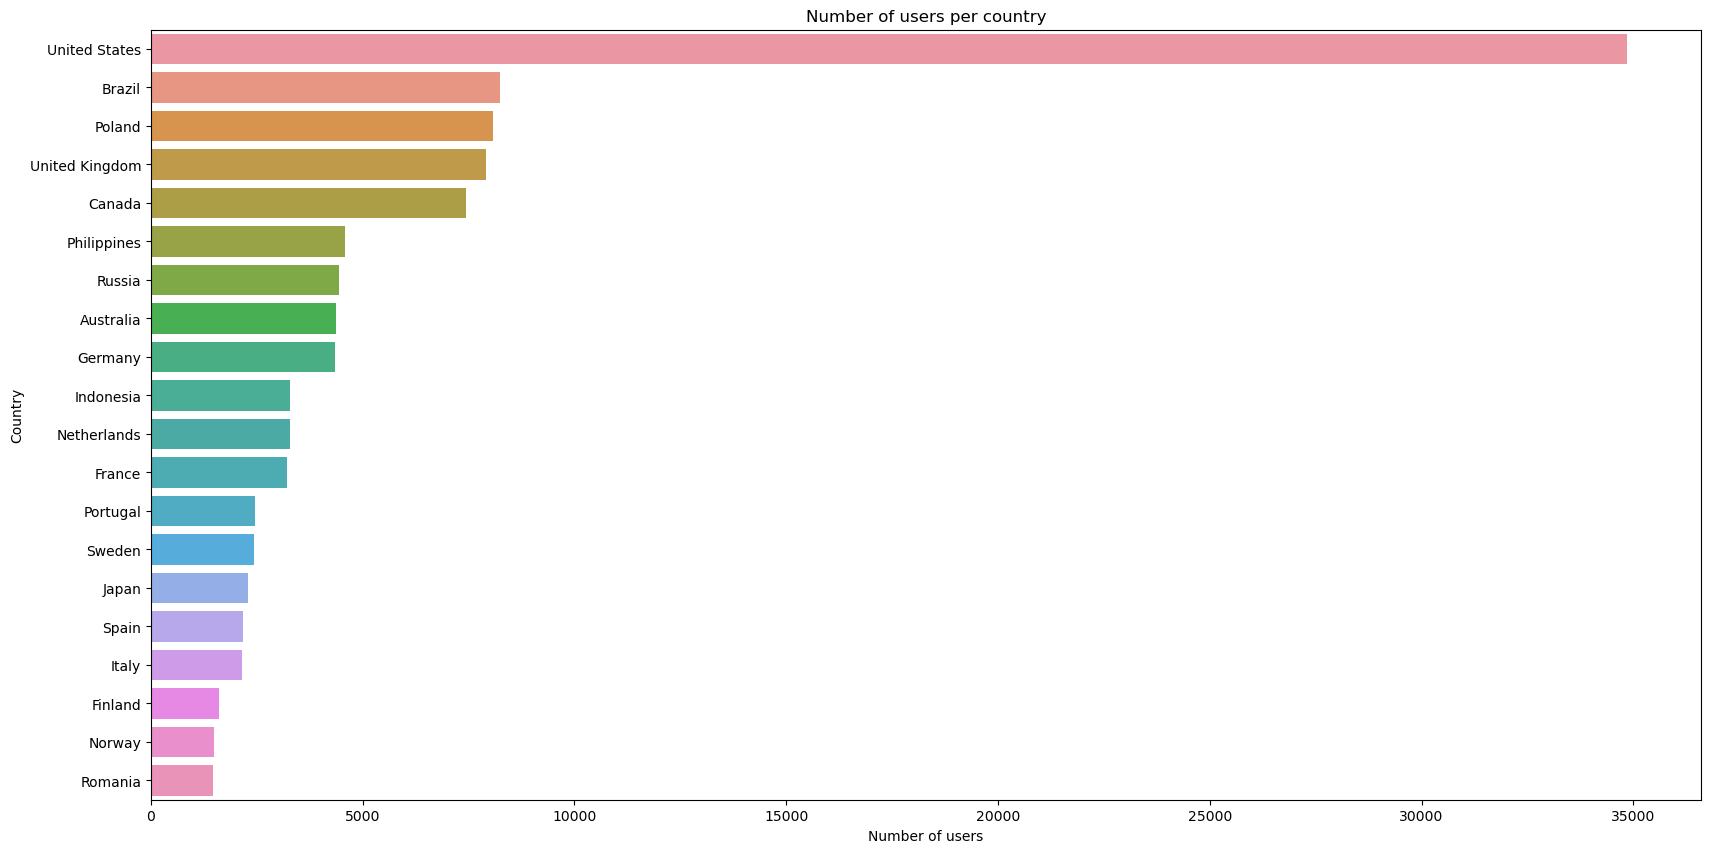

In [56]:
# histogram of the number of users per country
plt.figure(figsize=(20, 10))
sns.countplot(y="country", data=users, order=users["country"].value_counts()[:20].index)
plt.title("Number of users per country")
plt.xlabel("Number of users")
plt.ylabel("Country")
#plt.xticks(rotation=45)
plt.show()

In [57]:
# number of users in France
users[users["country"] == "France"]["user_id"].nunique()


3214

# Studios



In [58]:
df1 = pd.read_csv(data / "animes.csv")
df2 = pd.read_csv(data / "Anime.csv")

ratings = pd.read_csv(data / "ratings.csv")

In [59]:
df_animes = df1.merge(df2,left_on="title",right_on="Name")
df_animes.drop(columns=["season", "start_date", "Rating", "Release_year", "End_year", "Rank", "Name", "Type", "Release_season", "Episodes", "Japanese_name"], inplace=True)
df_animes

,anime_id,title,genres,media,episodes,rating,members,source,Studio,Tags,Description,Content_Warning,Related_Mange,Related_anime,Voice_actors,staff
0,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...","""Follow interstellar bounty hunters Spike Spie...","Drug Use,, Mature Themes,, Nudity,, Violence","Cowboy Bebop: Shooting Star, Cowboy Bebop","Cowboy Bebop Session XX: Mish-Mash Blues, Cowb...","Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana..."
1,6,Trigun,"Action,Sci-Fi,Adventure,Comedy,Drama,Shounen",tv,26,8.23,578887.0,manga,MADHOUSE,"Action, Adventure, Comedy, Drama, Shounen, Des...","'“Vash, the Stampede” - worth 60 billion dolla...",Violence,"Trigun, Trigun Maximum, Trigun: Multiple Bullets",Trigun: Badlands Rumble,"Meryl Stryfe : Hiromi Tsuru, Milly Thompson : ...","Yasuhiro Nightow : Original Creator, Satoshi N..."
2,7,Witch Hunter Robin,"Action,Mystery,Police,Supernatural,Drama,Magic",tv,26,7.27,96487.0,original,Sunrise,"Fantasy, Noir, Psychic Powers, Supernatural, S...",'STN is a secret organization charged with cap...,NaN,NaN,NaN,"Amon : Takuma Takewaka, Haruto Sakaki : Jun Fu...","Shuukou Murase : Director, Taku Iwasaki : Musi..."
3,15,Eyeshield 21,"Action,Sports,Comedy,Shounen",tv,145,7.94,152647.0,manga,Gallop,"Action, Comedy, Drama, Shounen, Sports, Footba...","'Sena was always a weak child, constantly havi...","Mature Themes,, Physical Abuse","Eyeshield 21 (Pilot), Eyeshield 21","Eyeshield 21: Maboroshi no Golden Bowl, Eyeshi...","Daikichi Komusubi : Hidenori Sakaki, Kazuki Ju...","Riichiro Inagaki : Original Creator, Yuusuke M..."
4,17,Hungry Heart: Wild Striker,"Slice of Life,Comedy,Sports,Shounen",tv,52,7.58,20934.0,manga,Nippon Animation,"Shounen, Sports, Soccer, Based on a Manga","""Kyousuke Kano aspires to become a professiona...",NaN,Hungry Heart - Wild Striker,NaN,"Kouji Sakai Jefferson : Masaya Takatsuka, Kyos...","Satoshi Saga : Director, Nobuyuki Nakamura : M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,42331,Renlei Bowuguan,"Slice of Life,Comedy",ona,36,NaN,249.0,original,NaN,"Fantasy, Chinese Animation, Non-Human Protagon...",No synopsis yet - check back soon!,NaN,NaN,NaN,NaN,NaN
5798,42332,Mengyou Dunhuang,"Comedy,Historical,Fantasy",ona,5,NaN,116.0,original,NaN,"Chinese Animation, Short Episodes",No synopsis yet - check back soon!,NaN,NaN,NaN,NaN,NaN
5799,42346,Hakata Bus Terminal Gorou,Comedy,ona,0,NaN,72.0,original,NaN,"Comedy, Short Episodes",'No synopsis yet - check back soon!',NaN,NaN,Hakata Bus Terminal Blues,Takashi Taniguchi\nDirector & Character Design,Takashi Taniguchi : Director & Character Design
5800,42347,Hakata Bus Terminal Blues,"Comedy,Music",music,1,NaN,91.0,original,NaN,"Comedy, Music, Shorts",An official theme song sung by the characters ...,NaN,NaN,Hakata Bus Terminal Gorou,NaN,NaN


In [60]:
df_users_ratings = ratings.merge(users[["user_id", "gender", "location", "birth_date", "join_date", "stats_mean_score", "stats_episodes"]], left_on="user_id", right_on="user_id")

In [61]:
df_studios = df_animes.merge(df_users_ratings, left_on="anime_id", right_on="anime_id")
df_studios.rename({"rating_x" : "average_rating"}, inplace=True)
df_studios.rename({"rating_y" : "rating_user"}, inplace=True)
df_studios

,anime_id,title,genres,media,episodes,rating_x,members,source,Studio,Tags,...,Voice_actors,staff,user_id,rating_y,gender,location,birth_date,join_date,stats_mean_score,stats_episodes
0,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",3,9,Male,"Oslo, Norway",1988-11-11,2004-11-11,7.31,3894.0
1,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",37,10,Female,"San Diego, California",1987-06-18,2005-02-12,8.07,1346.0
2,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",48,9,Female,South-east Asia,1987-12-31,2005-03-12,6.28,11408.0
3,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",66,8,Male,"Calgary, AB",1990-02-09,2005-04-01,7.53,4117.0
4,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Edward : Aoi Tada, Faye Valentine : Megumi Hay...","Sunrise : Original Creator, Shinichirou Watana...",82,7,Male,"Paris, France",1989-06-10,2005-04-29,7.17,2817.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815755,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Asuka'S Mother, Business Woman : Moemi Otaka, ...","Akira Funada : Producer & Director, Satoshi Um...",59541,2,Female,Toronto,NaN,2008-05-10,9.05,7502.0
815756,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Asuka'S Mother, Business Woman : Moemi Otaka, ...","Akira Funada : Producer & Director, Satoshi Um...",64816,6,Male,Malaysia,1988-11-11,2008-05-30,7.30,3218.0
815757,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Asuka'S Mother, Business Woman : Moemi Otaka, ...","Akira Funada : Producer & Director, Satoshi Um...",97939,1,Male,"Lithuania, Panevezys",NaN,2008-09-24,8.81,1132.0
815758,42284,Yuan Long,"Action,Adventure,Fantasy",ona,16,7.30,1484.0,novel,CG Year,"Action, Adventure, Fantasy, Chinese Animation,...",...,"Wang Sheng, Ming Song, Xu Ling, Yan Song, Yao ...","Ren Yuan : Original Creator, Guo Yong : Director",6958,7,Female,Brazil,NaN,2007-07-06,8.45,3574.0


In [62]:
# replace the location in dfFinalStudio with the country, with the help of locationToCountry. If the location is not in locationToCountry, then replace it with "Unknown"
df_studios["country"] = df_studios["location"].apply(
    lambda x: location_to_country[x] if x in location_to_country else ""
)
df_studios

,anime_id,title,genres,media,episodes,rating_x,members,source,Studio,Tags,...,staff,user_id,rating_y,gender,location,birth_date,join_date,stats_mean_score,stats_episodes,country
0,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",3,9,Male,"Oslo, Norway",1988-11-11,2004-11-11,7.31,3894.0,Norway
1,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",37,10,Female,"San Diego, California",1987-06-18,2005-02-12,8.07,1346.0,United States
2,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",48,9,Female,South-east Asia,1987-12-31,2005-03-12,6.28,11408.0,New Zealand
3,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",66,8,Male,"Calgary, AB",1990-02-09,2005-04-01,7.53,4117.0,United Kingdom
4,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,original,Sunrise,"Action, Adventure, Drama, Sci Fi, Bounty Hunte...",...,"Sunrise : Original Creator, Shinichirou Watana...",82,7,Male,"Paris, France",1989-06-10,2005-04-29,7.17,2817.0,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815755,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Akira Funada : Producer & Director, Satoshi Um...",59541,2,Female,Toronto,NaN,2008-05-10,9.05,7502.0,Canada
815756,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Akira Funada : Producer & Director, Satoshi Um...",64816,6,Male,Malaysia,1988-11-11,2008-05-30,7.30,3218.0,Malaysia
815757,42260,Ninja Collection,Supernatural,tv,13,3.85,12876.0,original,Drawiz,"Horror, Episodic, Ninja, Short Episodes, Super...",...,"Akira Funada : Producer & Director, Satoshi Um...",97939,1,Male,"Lithuania, Panevezys",NaN,2008-09-24,8.81,1132.0,Lithuania
815758,42284,Yuan Long,"Action,Adventure,Fantasy",ona,16,7.30,1484.0,novel,CG Year,"Action, Adventure, Fantasy, Chinese Animation,...",...,"Ren Yuan : Original Creator, Guo Yong : Director",6958,7,Female,Brazil,NaN,2007-07-06,8.45,3574.0,Brazil


In [63]:
df_studios["country"].value_counts()

United States     249147
Canada             50306
United Kingdom     49760
Poland             47113
Germany            28655
                   ...  
Angola                 4
Cambodia               3
Seychelles             3
Benin                  2
Chad                   1
Name: country, Length: 161, dtype: int64

In [64]:
df_studios["Studio"].value_counts()

MADHOUSE         87033
A-1 Pictures     42782
Bones            41347
J.C.Staff        32636
Sunrise          32367
                 ...  
Spring 2018          1
Urban Product        1
HiWaPlus             1
MooGoo               1
Spring 2015          1
Name: Studio, Length: 408, dtype: int64

In [65]:
df_studios["user_id"].nunique()

16347

In [66]:
# Aggregate for each Studio the counts for each country
df_studios_countries = (
    df_studios.groupby(["Studio", "country"])
    .agg({"user_id": "count"})
    .rename(columns={"user_id": "num_ratings"})
)  # .reset_index()
df_studios_countries

num_ratings
Studio         country               
2:10 Animation Brazil               1
               Hungary              1
               Norway               1
3xCube         Argentina            2
               Australia           24
...                               ...
ufotable       Venezuela           25
               Vietnam             21
               Warsaw               3
               Yemen                6
               Zimbabwe             5

[15862 rows x 1 columns]

In [67]:
# In df_test, for each Studio, sort the countries by the number of ratings
#df_studios_countries = df_studios_countries.groupby(level=0).apply(
#    lambda x: x.sort_values("num_ratings", ascending=False)
#)
df_studios_countries.reset_index(inplace=True)
df_studios_countries.sort_values(by=['num_ratings'], ascending=False, inplace=True)
df_studios_countries.head(70)
#df_studios_countries[df_studios_countries['num_ratings'] >= 500]['Studio'].value_counts()

,Studio,country,num_ratings
7248,MADHOUSE,United States,26615
459,A-1 Pictures,United States,12786
2436,Bones,United States,12529
6006,J.C.Staff,United States,10071
12779,Sunrise,United States,9959
...,...,...,...
6308,Khara,United States,1614
9609,Production I.G,United Kingdom,1567
9495,Production I.G,Canada,1563
11797,Studio DEEN,United Kingdom,1558


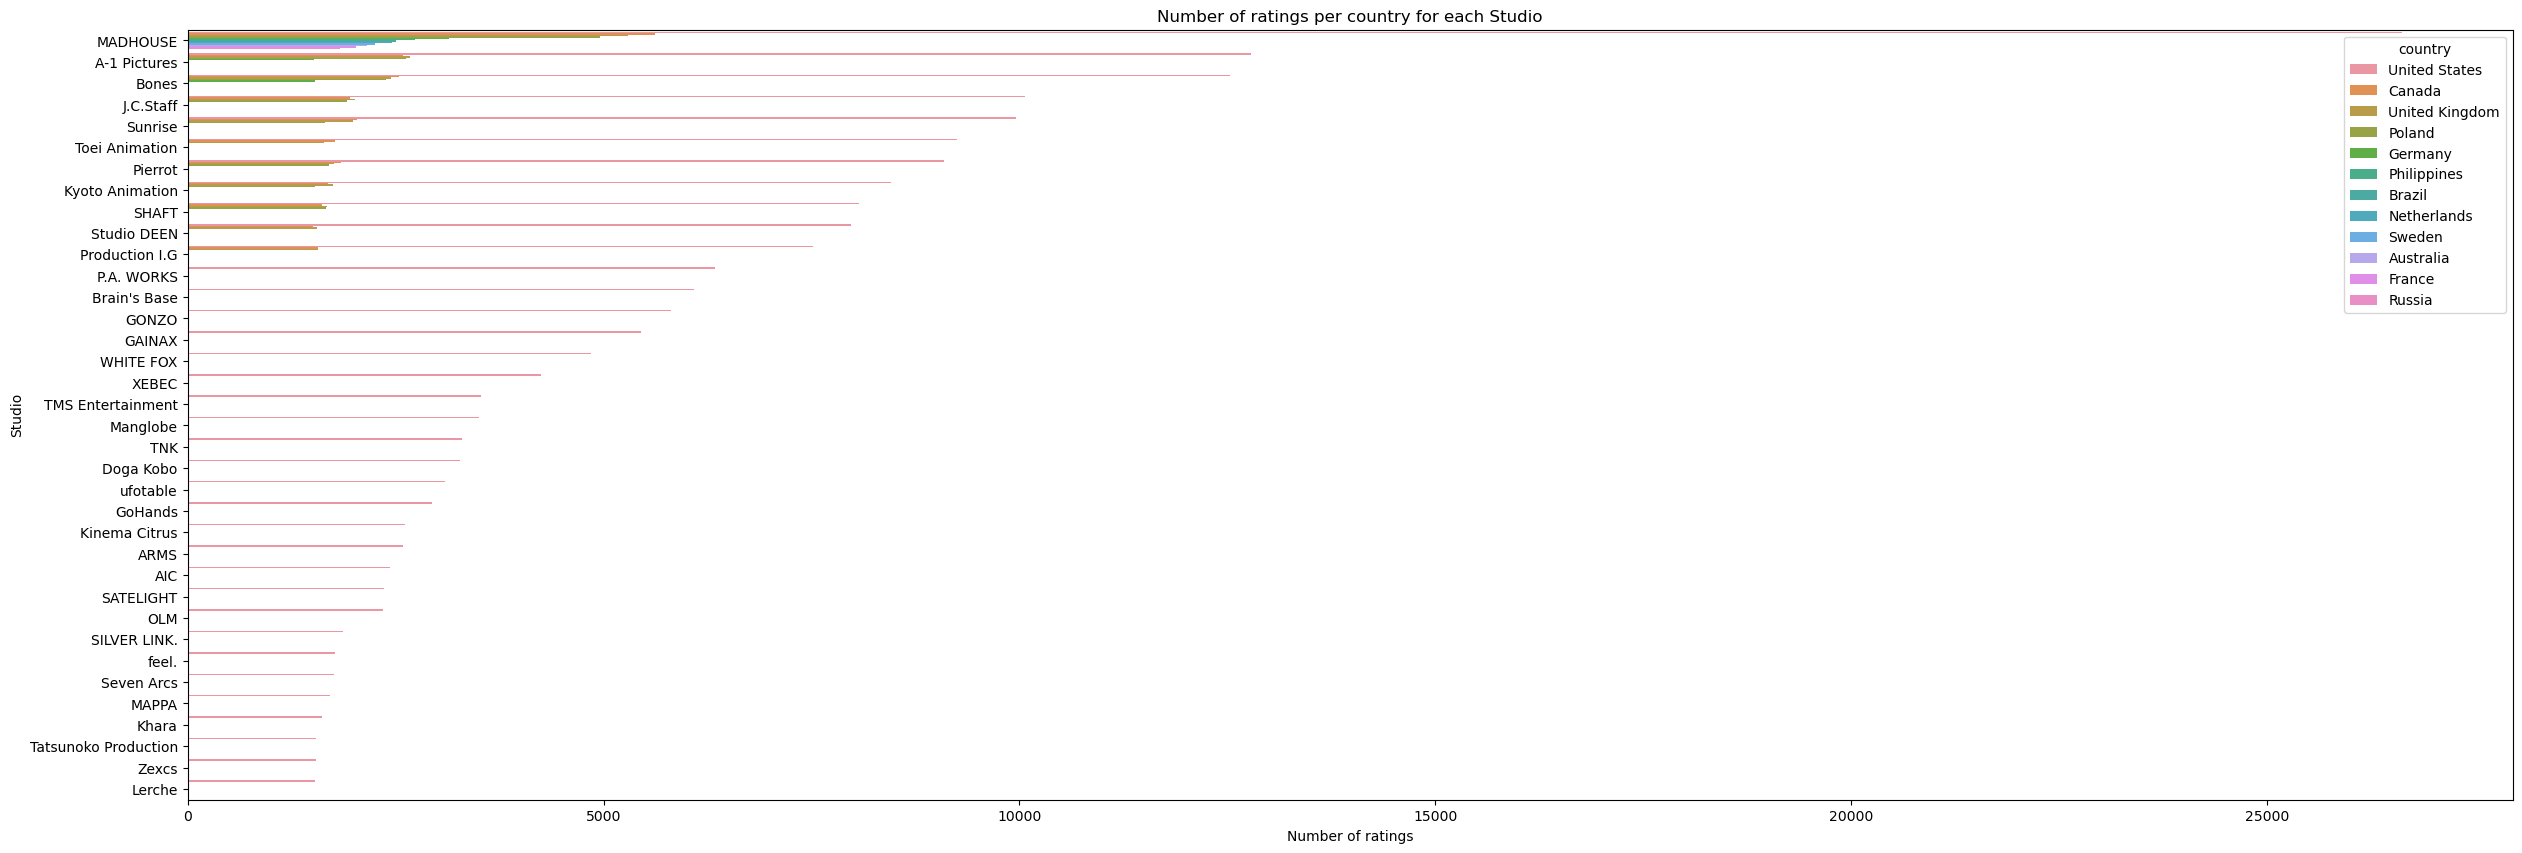

In [68]:
# plot df_studios_countries
plt.figure(figsize=(30, 10))
sns.barplot(
    x="num_ratings",
    y="Studio",
    hue="country",
    data=df_studios_countries[df_studios_countries['num_ratings'] >= 1500],
    order=df_studios_countries[df_studios_countries['num_ratings'] >= 1500]["Studio"].unique(),
)
plt.title("Number of ratings per country for each Studio")
plt.xlabel("Number of ratings")
plt.ylabel("Studio")
plt.show()
# number of ratings per Studio
#df_studios_countries.groupby("Studio").sum()


In [69]:
df_studio_per_country = df_studios_countries.copy()[['Studio', 'country']]
df_studio_per_country = df_studio_per_country.groupby(['Studio']).count()
df_studio_per_country.reset_index(inplace=True)
df_studio_per_country.sort_values(by=['country'], ascending=False, inplace=True)
df_studio_per_country.head()

,Studio,country
193,MADHOUSE,153
54,Bones,150
239,Pierrot,149
226,P.A. WORKS,144
6,A-1 Pictures,144


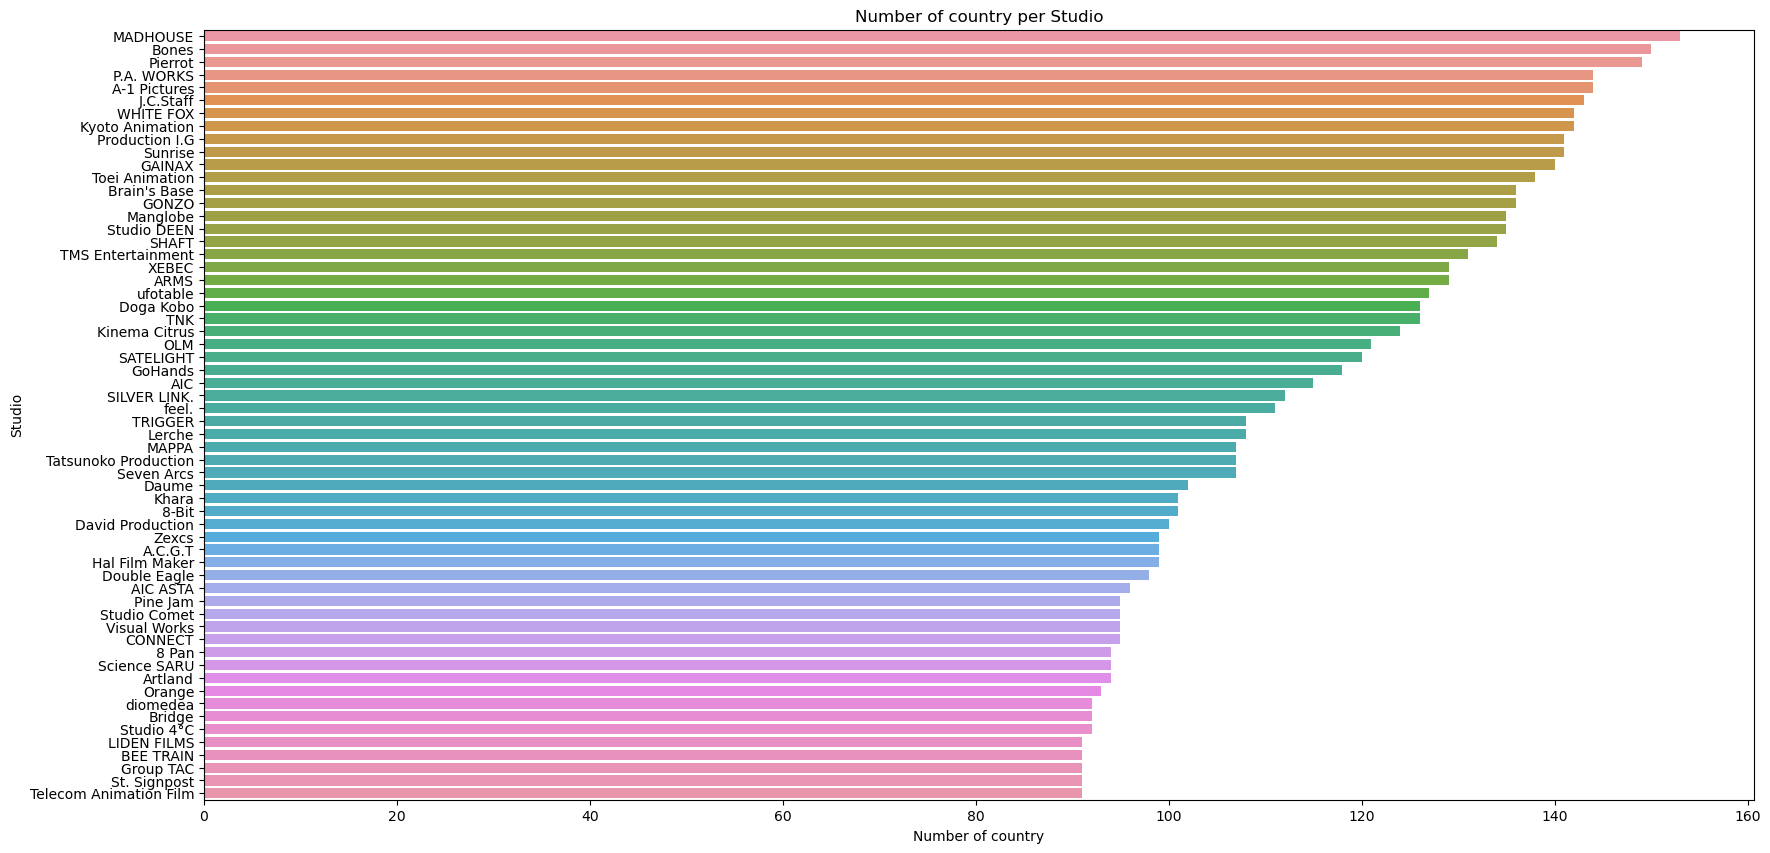

In [70]:
plt.figure(figsize=(20, 10))
sns.barplot(
    x="country",
    y="Studio",
    data=df_studio_per_country[df_studio_per_country['country'] >=90],
    order=df_studio_per_country[df_studio_per_country['country'] >=90]["Studio"].unique(),
)
plt.title("Number of country per Studio")
plt.xlabel("Number of country")
plt.ylabel("Studio")
plt.show()

In [71]:
# Print for Studio == "MADHOUSE"
df_studios_countries[df_studios_countries['Studio'] == "MADHOUSE"].head(10)

,Studio,country,num_ratings
7248,MADHOUSE,United States,26615
7123,MADHOUSE,Canada,5619
7247,MADHOUSE,United Kingdom,5298
7214,MADHOUSE,Poland,4955
7148,MADHOUSE,Germany,3147
7213,MADHOUSE,Philippines,2739
7120,MADHOUSE,Brazil,2510
7197,MADHOUSE,Netherlands,2454
7233,MADHOUSE,Sweden,2250
7109,MADHOUSE,Australia,2155


In [72]:
df_studios_countries[df_studios_countries['Studio'] == "A-1 Pictures"].head(10)

,Studio,country,num_ratings
459,A-1 Pictures,United States,12786
458,A-1 Pictures,United Kingdom,2672
427,A-1 Pictures,Poland,2628
342,A-1 Pictures,Canada,2595
363,A-1 Pictures,Germany,1522
426,A-1 Pictures,Philippines,1339
339,A-1 Pictures,Brazil,1139
410,A-1 Pictures,Netherlands,1082
445,A-1 Pictures,Sweden,1047
329,A-1 Pictures,Australia,1033


In [73]:
df_studios_sum_ratings = df_studios_countries.copy()
df_studios_sum_ratings = df_studios_sum_ratings[['Studio', 'num_ratings']].groupby(['Studio']).sum()
df_studios_sum_ratings.reset_index(inplace=True)
df_studios_sum_ratings.sort_values(by=['num_ratings'], ascending=False, inplace=True)
df_studios_sum_ratings.head(10)

,Studio,num_ratings
193,MADHOUSE,87033
6,A-1 Pictures,42782
54,Bones,41347
157,J.C.Staff,32636
340,Sunrise,32367
239,Pierrot,29706
357,Toei Animation,29629
177,Kyoto Animation,27959
258,SHAFT,27116
305,Studio DEEN,25328


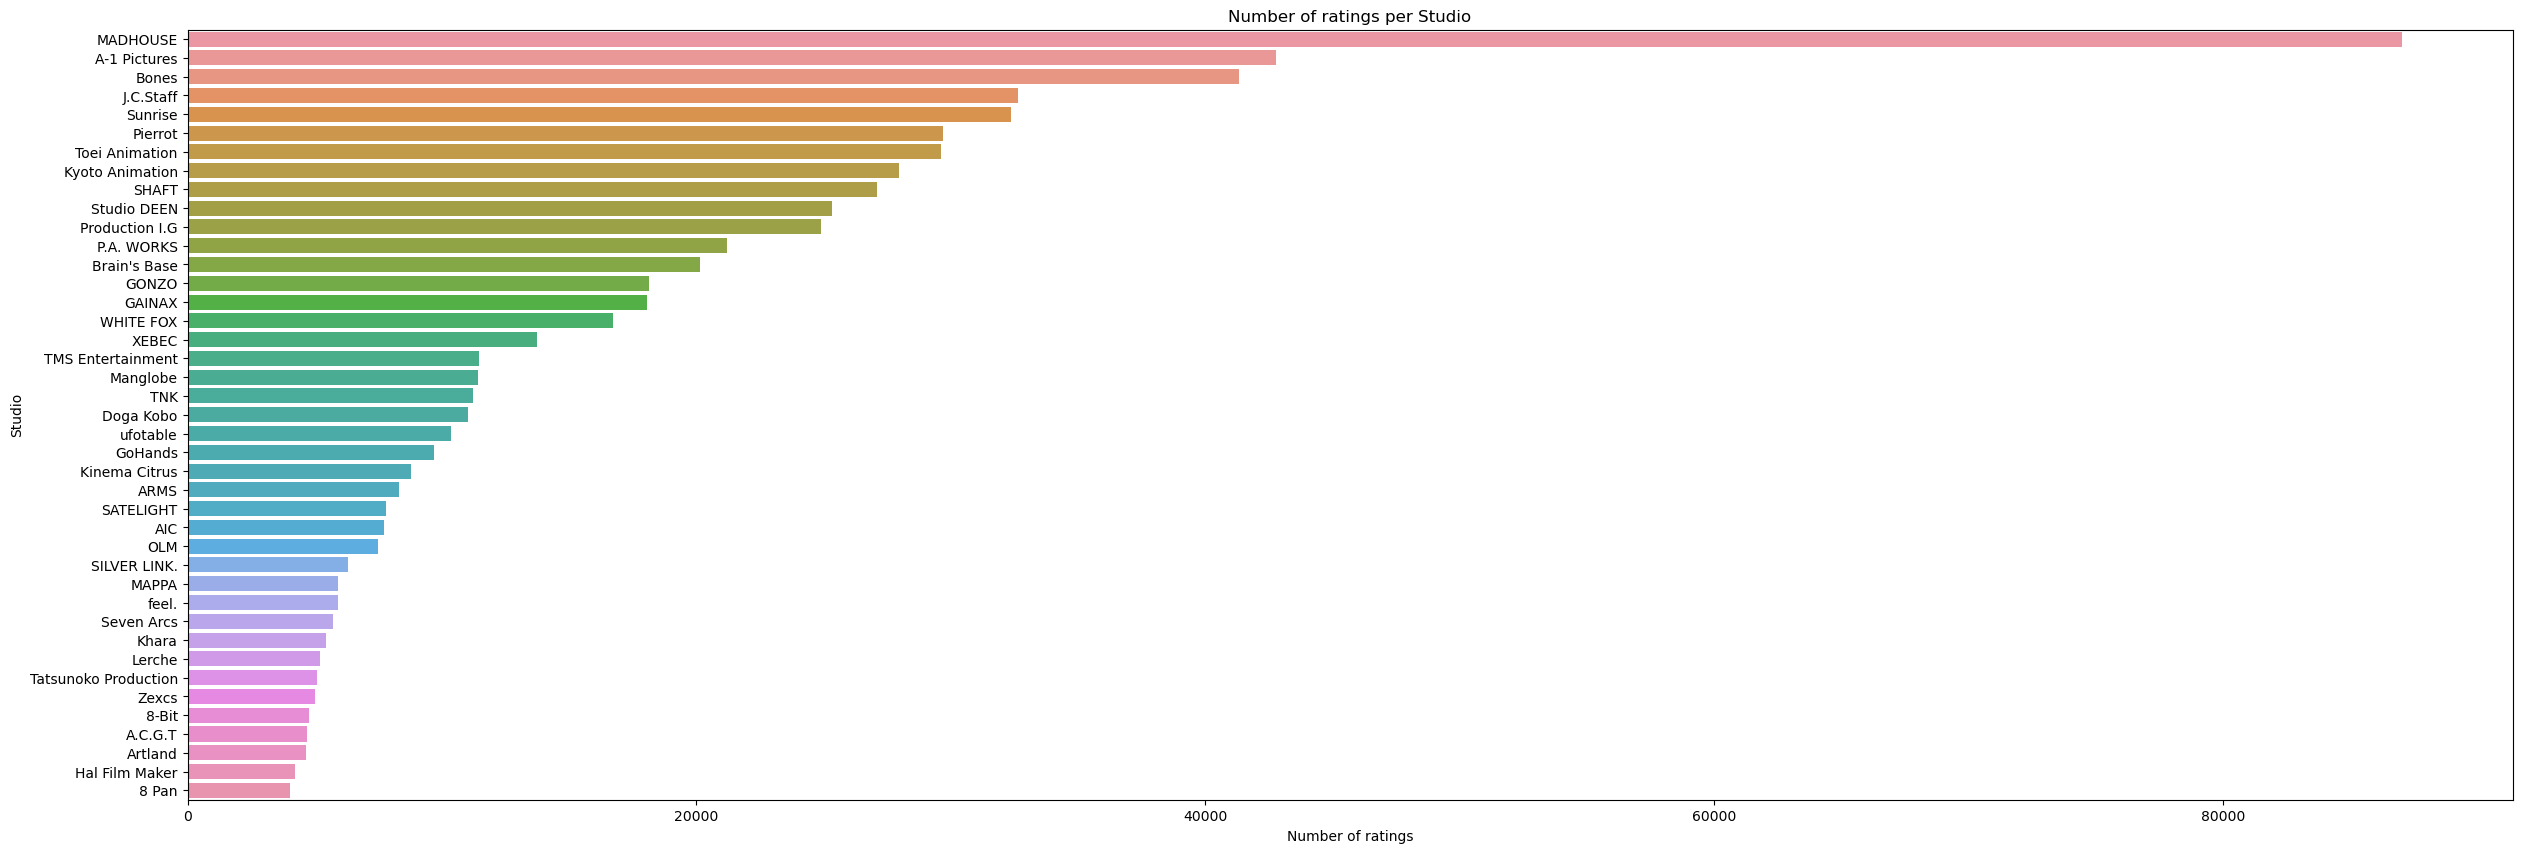

In [74]:
plt.figure(figsize=(30, 10))
sns.barplot(
    x="num_ratings",
    y="Studio",
    data=df_studios_sum_ratings[df_studios_sum_ratings['num_ratings'] >= 4000],
    order=df_studios_sum_ratings[df_studios_sum_ratings['num_ratings'] >= 4000]["Studio"].unique(),
)
plt.title("Number of ratings per Studio")
plt.xlabel("Number of ratings")
plt.ylabel("Studio")
plt.show()

In [75]:
import dask.dataframe as dd

df = dd.read_csv(data /
    "UserAnimeList.csv",
    dtype={
        "username": "object",
        "anime_id": "int64",
        "my_watched_episodes": "int64",
        "my_start_date": "str",
        "my_finish_date": "str",
        "my_score": "int64",
        "my_status": "int64",
        "my_rewatching": "float64",
        "my_rewatching_ep": "int64",
        "my_last_updated": "int64",
        "my_tags": "object",
    },
    usecols=[
        "username",
        "anime_id",
        "my_watched_episodes",
        "my_start_date",
        "my_finish_date",
        "my_score",
        "my_status",
        "my_rewatching",
        "my_rewatching_ep",
        "my_last_updated",
        "my_tags",
    ],
    storage_options={"anon": True},
    blocksize="16 MiB",
).persist()

df

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
npartitions=297,,,,,,,,,,,
,object,int64,int64,object,object,int64,int64,float64,int64,int64,object
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [76]:
df["username"].nunique().compute()

283044

In [77]:
df["anime_id"].nunique().compute()

14478

In [78]:
df.shape[0].compute()

80076112

In [79]:
# group by username and create a column "num_ratings" which counts the number of anime_id per username
user_ratings = (
    df.groupby("username")
    .agg({"anime_id": "count"})
    .rename(columns={"anime_id": "num_ratings"})
).compute()
user_ratings

,num_ratings
username,
--Akira,1
--Andrea--,71
--ELITE--,76
--Etsuko--,119
--FallenAngel--,573
...,...
zzganz,758
zzryu,99
zzz4454,62


In [80]:
# print the rows where username="karthiga"
df[df["username"] == "RedvelvetDaisuki"].compute()


,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
53,RedvelvetDaisuki,1,26,2012-00-00,2014-08-08,8,2,NaN,0,1407479649,NaN
54,RedvelvetDaisuki,7,0,0000-00-00,0000-00-00,0,6,0.0,0,1355478414,NaN
55,RedvelvetDaisuki,16,4,2013-03-23,0000-00-00,4,3,NaN,0,1364134472,NaN
56,RedvelvetDaisuki,19,74,2012-12-14,2012-12-19,9,2,NaN,0,1355935732,NaN
57,RedvelvetDaisuki,20,220,2012-08-00,2012-08-00,9,2,NaN,0,1355471991,NaN
...,...,...,...,...,...,...,...,...,...,...,...
750,RedvelvetDaisuki,35849,15,2018-04-07,0000-00-00,0,1,0.0,0,1525445239,NaN
751,RedvelvetDaisuki,35857,5,2018-04-00,0000-00-00,10,1,0.0,0,1525445957,NaN
752,RedvelvetDaisuki,35860,12,2018-04-02,2018-04-02,5,2,0.0,0,1522821087,NaN
753,RedvelvetDaisuki,36027,12,2018-02-14,2018-02-14,2,2,0.0,0,1518615703,NaN


In [81]:
# sort by my_finish_date
df["my_finish_date"].max().compute()

'6553-00-00'

In [82]:
# Join df with users on username
df_test = df.merge(users_cleaned, left_on="username", right_on="username").persist()
df_test

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
npartitions=297,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,int64,int64,object,object,int64,int64,float64,int64,int64,object,int64,int64,int64,int64,int64,int64,float64,object,object,object,float64,object,object,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [83]:
df_test.shape[0].compute()

33701824

# Genre Anime

In [84]:
dfAnime = pd.read_csv(data /'animes.csv')
dfAnime.head(5)

,anime_id,title,genres,media,episodes,rating,members,start_date,season,source
0,1,Cowboy Bebop,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",tv,26,8.77,1324054.0,1998/4/3,spring_1998,original
1,5,Cowboy Bebop: Tengoku no Tobira,"Action,Drama,Mystery,Sci-Fi,Space",movie,1,8.39,284827.0,2001/9/1,summer_2001,original
2,6,Trigun,"Action,Sci-Fi,Adventure,Comedy,Drama,Shounen",tv,26,8.23,578887.0,1998/4/1,spring_1998,manga
3,7,Witch Hunter Robin,"Action,Mystery,Police,Supernatural,Drama,Magic",tv,26,7.27,96487.0,2002/7/2,summer_2002,original
4,8,Bouken Ou Beet,"Adventure,Fantasy,Shounen,Supernatural",tv,52,6.97,13450.0,2004/9/30,fall_2004,manga


In [85]:
dfCam = dfAnime.copy()[['anime_id', 'title', 'genres', 'rating', 'start_date']]
dfCam['start_date'] = dfCam['start_date'].apply(lambda x : x.split('/')[0])
dfCam.dropna(subset=['genres'], inplace=True)
dfCam = dfCam[dfCam['genres'] != None]
dfCam['genres'] = dfCam['genres'].apply(lambda x : [y.split('"')[0] for y in x.split(',')])
accumulateurGenre = {}
def accumulate(x) : 
    if x in [*accumulateurGenre] : return
    for genre in x :
        if not (genre in [*accumulateurGenre]) : 
            accumulateurGenre[genre] = 0
    return
dfCam['genres'].apply(lambda x : accumulate(x))
def countByGenre(x) : 
    for keys in accumulateurGenre.keys() :
        if keys in x :
            accumulateurGenre[keys] += 1
dfCam['genres'].apply(lambda x : countByGenre(x))
print(accumulateurGenre)
sortAccumulateur = sorted(accumulateurGenre.items(), key=lambda x : x[1])
listGenreDelete = [g for g, v in sortAccumulateur if v < 120]
sortAccumulateur = sortAccumulateur[len(listGenreDelete):][::-1]
print(listGenreDelete)
dfCam['genres'] = dfCam['genres'].apply(lambda x : [s for s in x if not (s in listGenreDelete)])
dfCam['length'] = dfCam['genres'].apply(lambda x : len(x))
dfCam = dfCam[dfCam['length'] > 0]
dfCam.drop(columns='length', inplace=True)
listGenre = [g for g, v in sortAccumulateur if not (g in listGenreDelete)]
print(listGenre)
dfCam['Encode_genres'] = dfCam['genres'].apply(lambda x: [1 if s in x else 0 for s in listGenre])
dfCam[listGenre] = pd.DataFrame(dfCam.Encode_genres.tolist(), index = dfCam.index)
dfCam.drop(columns=['genres', 'Encode_genres'], inplace=True)
dfCam.head(5)

{'Action': 3569, 'Adventure': 2714, 'Comedy': 5610, 'Drama': 2252, 'Sci-Fi': 2409, 'Space': 455, 'Mystery': 676, 'Shounen': 1889, 'Police': 234, 'Supernatural': 1359, 'Magic': 1029, 'Fantasy': 2916, 'Sports': 654, 'Josei': 93, 'Romance': 1793, 'Slice of Life': 1757, 'Cars': 119, 'Seinen': 801, 'Horror': 426, 'Psychological': 306, 'Thriller': 120, 'Super Power': 591, 'Martial Arts': 367, 'School': 1569, 'Ecchi': 746, 'Vampire': 130, 'Military': 526, 'Historical': 911, 'Dementia': 202, 'Mecha': 1044, 'Demons': 447, 'Samurai': 182, 'Game': 364, 'Shoujo': 668, 'Harem': 393, 'Music': 1891, 'Shoujo Ai': 76, 'Shounen Ai': 91, 'Kids': 1952, 'Hentai': 1317, 'Parody': 635, 'Yuri': 32, 'Yaoi': 40, 'Sinen': 1}
['Sinen', 'Yuri', 'Yaoi', 'Shoujo Ai', 'Shounen Ai', 'Josei', 'Cars']
['Comedy', 'Action', 'Fantasy', 'Adventure', 'Sci-Fi', 'Drama', 'Kids', 'Music', 'Shounen', 'Romance', 'Slice of Life', 'School', 'Supernatural', 'Hentai', 'Mecha', 'Magic', 'Historical', 'Seinen', 'Ecchi', 'Mystery', 'Sho

,anime_id,title,rating,start_date,Comedy,Action,Fantasy,Adventure,Sci-Fi,Drama,...,Horror,Harem,Martial Arts,Game,Psychological,Police,Dementia,Samurai,Vampire,Thriller
0,1,Cowboy Bebop,8.77,1998,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,2001,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,6,Trigun,8.23,1998,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,7,Witch Hunter Robin,7.27,2002,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,8,Bouken Ou Beet,6.97,2004,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
statList = []
count2 = []
#count3 = []
nb = dfCam.shape[0]
for gp in listGenre : 
    dfgp = dfCam[dfCam[gp] == 1]
    for g2 in listGenre[:6] :
        if g2 != gp : #and not (([gp, g2] in count2) or ([g2, gp] in count2)):
            dfg2 = dfgp[dfgp[g2] == 1]
            for g3 in listGenre[:6] :
                if g3 != g2 and g3 != gp : #and not (([gp, g2, g3] in count3) or ([gp, g3, g2] in count3) or ([g2, gp, g3] in count3) or ([g2, g3, gp] in count3) or ([g3, gp, g2] in count3) or ([g3, g2, gp] in count3)):
                    dfg3 = dfg2[dfg2[g3] == 1]
                    statList.append([gp, g2, g3, dfg3.shape[0], dfg3.shape[0]*100.0/dfg2.shape[0]])
                    #count3.append([g3])
            statList.append([gp, g2, "T", dfg2.shape[0], dfg2.shape[0]*100.0/dfgp.shape[0]])
            #count2.append([gp, g2])
    statList.append([gp, "T", "T", dfgp.shape[0], dfgp.shape[0]*100.0/nb])
print(statList)
print(len(statList))

[['Comedy', 'Action', 'Fantasy', 326, 30.38210624417521], ['Comedy', 'Action', 'Adventure', 441, 41.09972041006524], ['Comedy', 'Action', 'Sci-Fi', 267, 24.88350419384902], ['Comedy', 'Action', 'Drama', 133, 12.39515377446412], ['Comedy', 'Action', 'T', 1073, 19.126559714795007], ['Comedy', 'Fantasy', 'Action', 326, 31.589147286821706], ['Comedy', 'Fantasy', 'Adventure', 476, 46.12403100775194], ['Comedy', 'Fantasy', 'Sci-Fi', 87, 8.430232558139535], ['Comedy', 'Fantasy', 'Drama', 106, 10.271317829457365], ['Comedy', 'Fantasy', 'T', 1032, 18.39572192513369], ['Comedy', 'Adventure', 'Action', 441, 42.08015267175573], ['Comedy', 'Adventure', 'Fantasy', 476, 45.41984732824427], ['Comedy', 'Adventure', 'Sci-Fi', 209, 19.942748091603054], ['Comedy', 'Adventure', 'Drama', 125, 11.927480916030534], ['Comedy', 'Adventure', 'T', 1048, 18.680926916221033], ['Comedy', 'Sci-Fi', 'Action', 267, 37.5], ['Comedy', 'Sci-Fi', 'Fantasy', 87, 12.219101123595506], ['Comedy', 'Sci-Fi', 'Adventure', 209, 29

In [88]:
dftest = pd.DataFrame(statList, columns=['Genre_Principal', "Genre_Secondaire_1", "Genre_Secondaire_2", "Count", "Percent"])
dftest.head(45)

,Genre_Principal,Genre_Secondaire_1,Genre_Secondaire_2,Count,Percent
0,Comedy,Action,Fantasy,326,30.382106
1,Comedy,Action,Adventure,441,41.099720
2,Comedy,Action,Sci-Fi,267,24.883504
3,Comedy,Action,Drama,133,12.395154
4,Comedy,Action,T,1073,19.126560
5,Comedy,Fantasy,Action,326,31.589147
6,Comedy,Fantasy,Adventure,476,46.124031
7,Comedy,Fantasy,Sci-Fi,87,8.430233
8,Comedy,Fantasy,Drama,106,10.271318
9,Comedy,Fantasy,T,1032,18.395722


In [95]:
df_sum_genre = pd.DataFrame.from_dict(
    accumulateurGenre, orient="index", columns=["count_anime"]
)
df_sum_genre.index.name = 'genre'
df_sum_genre.reset_index(inplace=True)
df_sum_genre.head()


,genre,count_anime
0,Action,3569
1,Adventure,2714
2,Comedy,5610
3,Drama,2252
4,Sci-Fi,2409


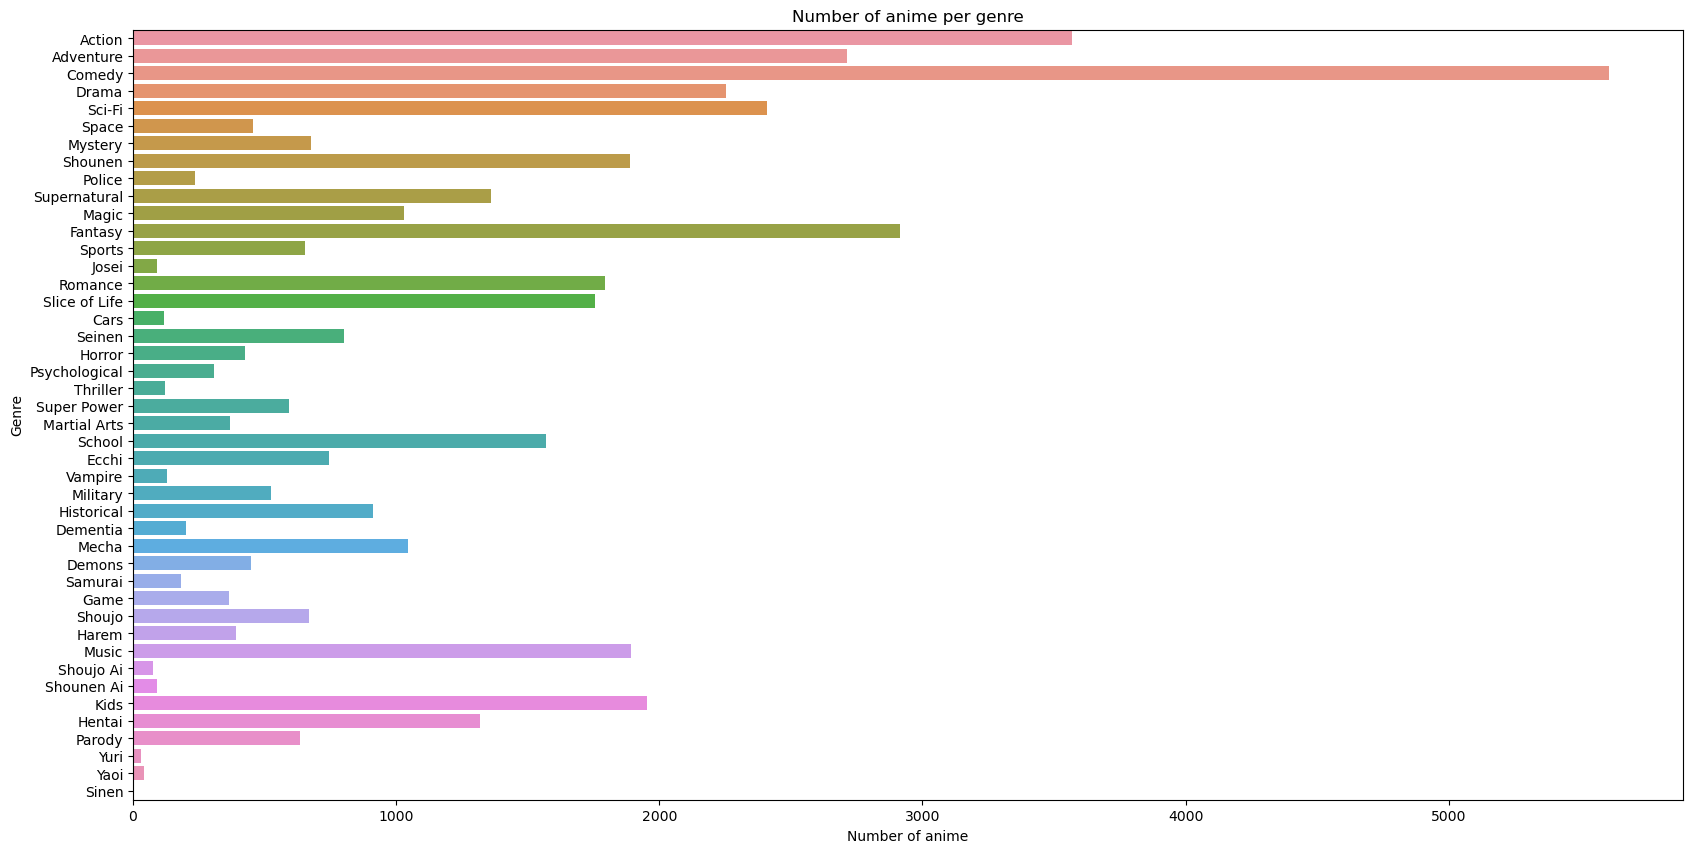

In [98]:
plt.figure(figsize=(20, 10))
sns.barplot(
    x="count_anime",
    y="genre",
    data=df_sum_genre,
    order=df_sum_genre["genre"].unique(),
)
plt.title("Number of anime per genre")
plt.xlabel("Number of anime")
plt.ylabel("Genre")
plt.show()